In [7]:
import os
import json
import pickle
import pandas as pd
from pandas.api.types import is_float_dtype
from collections import defaultdict
from utils.constant import ViTExperiment
from itertools import product

In [8]:
# 変数の定義
ds = "tiny-imagenet"
k = 0
tgt_rank_list = [1, 2, 3]
misclf_type_list = ["src_tgt", "tgt"]
fpfn_list = [None, "fp", "fn"]
tgt_split_list = ["repair", "test"]
num_reps = 5
alpha = 10 / 11
fl_method_list = ["ours", "arachne", "random_o", "random_a"]

In [9]:
# 保存先ディレクトリ（仮定）
exp_obj = getattr(ViTExperiment, ds.replace("-", "_"))
pretrained_dir = exp_obj.OUTPUT_DIR.format(k=k)

# 結果の格納用
results = defaultdict(list)
for fl_method in fl_method_list:
    # 論文表記のmethod nameから内部ファイルで使用しているmethod nameに変換
    _fl_method = fl_method
    if _fl_method.startswith("random_"):
        _fl_method = "random"
    if _fl_method == "arachne":
        _fl_method = "bl"
    # ファイル名関連の設定
    if fl_method == "ours" or fl_method == "random_o":
        w_num = 472
        id_prefix = "4-1"
    else:
        w_num = None
        if fl_method == "arachne":
            id_prefix = "3-1"
        else:
            id_prefix = "3-2"
    setting_id = f"n{w_num}_alpha{alpha}_boundsArachne" if w_num is not None else f"alpha{alpha}_boundsArachne"
    
    for tgt_rank, misclf_type, fpfn in product(tgt_rank_list, misclf_type_list, fpfn_list):
        if (misclf_type in ["src_tgt", "all"] and fpfn is not None) or (misclf_type == "tgt" and fpfn is None):
            continue

        misclf_ptn = misclf_type if fpfn is None else f"{misclf_type}_{fpfn}"
        save_dir = os.path.join(pretrained_dir, f"misclf_top{tgt_rank}", f"{misclf_ptn}_repair_weight_by_de")
        row = {"ds": ds, "tgt_rank": tgt_rank, "misclf_type": misclf_ptn, "fl_method": fl_method}

        rr_list, br_list, racc_list, diff_corr_list, t_repair_list = [], [], [], [], []
        for reps_id in range(num_reps):
            filename = f"exp-repair-{id_prefix}-tracker_{setting_id}_{_fl_method}_reps{reps_id}.pkl"
            pkl_path = os.path.join(save_dir, filename)
            if not os.path.exists(pkl_path):
                raise FileNotFoundError(f"pickle file not found: {pkl_path}")
            with open(pkl_path, "rb") as f:
                d = pickle.load(f)
            num_steps = len(d["fitness"]) - 1
            results[fl_method].append(num_steps)

In [10]:
results.keys()

dict_keys(['ours', 'arachne', 'random_o', 'random_a'])

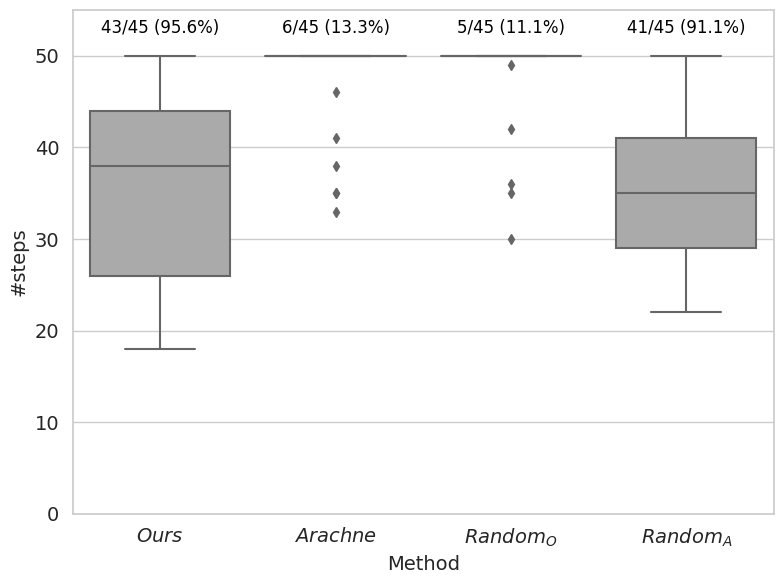

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# method_orderと表示名の対応
method_order = ['ours', 'arachne', 'random_o', 'random_a']
method_display_names = {
    'ours': '$Ours$',
    'arachne': '$Arachne$',
    'random_o': '$Random_O$',
    'random_a': '$Random_A$'
}

# グレー1色で統一
gray_color = "#AAAAAA"
uniform_palette = [gray_color] * len(method_order)

# DataFrame構築
records = []
for method in method_order:
    for s in results[method]:
        records.append({
            "Method": method,
            "#steps": s,
            "Early Stopping": s != 50
        })
df = pd.DataFrame(records)

# 表示用ラベル列を追加
df["Method"] = df["Method"].map(method_display_names)

# seabornの設定
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

# Boxplot本体
ax = sns.boxplot(data=df, x="Method", y="#steps", palette=uniform_palette, order=[method_display_names[m] for m in method_order])
# ★ ここで目盛（値）のフォントサイズを 12pt に統一
ax.tick_params(axis='both', labelsize=14)
# （任意）ラベル自体のフォントサイズも変える場合
ax.set_xlabel("Method", fontsize=14)
ax.set_ylabel("#steps", fontsize=14)
# アノテーション
for i, method in enumerate(method_order):
    label = method_display_names[method]
    total = df[df["Method"] == label].shape[0]
    early = df[(df["Method"] == label) & (df["Early Stopping"])].shape[0]
    pct = early / total * 100
    ax.text(i, 52, f"{early}/{total} ({pct:.1f}%)", 
            ha='center', va='bottom', fontsize=12, color='black')

plt.ylim(0, 55)
plt.tight_layout()


# pdfとして保存
output_pdf_path = "./stat_num_steps.pdf"
plt.savefig(output_pdf_path, format='pdf', bbox_inches='tight', dpi=300)
plt.show()